<a href="https://colab.research.google.com/github/RomanPenzov/CalculatorArabRom/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%90%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D0%B0_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B0_(Autoencoder)_%7C_%D0%94%D0%97_Lite_%7C_%D0%A3%D0%98%D0%98%22_%D0%9F%D0%B5%D0%BD%D0%B7%D0%BE%D0%B2_%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание

Добейтесь на автокодировщике с 2-мерным скрытым пространством на 3-х цифрах: 0, 1 и 3 – ошибки MSE**<0.034** на скорости обучения **0.001** на **10-й эпохе**.

## Импорт библиотек


In [ ]:
# Работа с операционной системой
import tensorflow as tf
import os

# Отрисовка графиков
import matplotlib.pyplot as plt 

# Операции с путями
import glob

# Работа с массивами данных
import numpy as np

# Слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Concatenate

# Модель
from tensorflow.keras import Model

# Загрузка модели
from tensorflow.keras.models import load_model

# Датасет
from tensorflow.keras.datasets import mnist

# Оптимизатор для обучения модели
from tensorflow.keras.optimizers import Adam

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

%matplotlib inline

## Утилиты

Функция-коллбэк. Отрисовывает объекты в скрытом пространстве

In [ ]:
def ae_on_epoch_end(epoch, logs):
    print('________________________')  
    print(f'*** ЭПОХА: {epoch+1}, loss: {logs["loss"]} ***')
    print('________________________')  
    
    # Получение картинки латентного пространства в конце эпохи и запись в файл
    # Задание числа пикселей на дюйм
    plt.figure(dpi=100)

    # Предсказание енкодера на тренировочной выборке
    predict = encoder.predict(X_train)

    # Создание рисунка: множество точек на плоскости 3-х цветов (3-х классов)
    scatter = plt.scatter(predict[:,0,],predict[:,1], c=y_train, alpha=0.6, s=5)

    # Создание легенды
    legend2 = plt.legend(*scatter.legend_elements(), loc='upper right', title='Классы')

    # Сохранение картинки с названием, которого еще нет
    paths = glob.glob('*.jpg')
    plt.savefig(f'image_{str(len(paths))}.jpg')

    # Отображение. Без него рисунок не отрисуется
    plt.show()


ae_callback = LambdaCallback(on_epoch_end=ae_on_epoch_end)

Удаление изображений. Применять при обучении новой модели, чтобы не было путаницы в картинках.

In [ ]:
def clean():
  # Получение названий всех картинок
  paths = glob.glob('*.jpg')

  # Удаление всех картинок по полученным путям
  for p in paths:
    os.remove(p)

# Удаление всех картинок
clean()

## Загрузка данных

In [ ]:
# Загрузка датасета
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# Нормировка
X_train = X_train.astype('float32')/255.
X_train = X_train.reshape(-1, 28, 28, 1)

In [ ]:
# Выбор визуализируемых классов (цифр) и формирование подвыборок для них по маске
numbers = [0, 1, 3]
mask = np.array([(i in numbers) for i in y_train])
X_train = X_train[mask]
y_train = y_train[mask]

## Создание модели и обучение

In [ ]:
# Ваше решение
# размерность входа
in_shape = 28, 28, 1

# латентное пространство - размерность равна 2 ПО УСЛОВИЮ ЗАДАЧИ
latent_dim = 2

# ЭНКОДЕР
inputs = Input(in_shape)
x = Conv2D(8, 3, padding='same', dilation_rate=2, activation='elu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(16, 3, padding='same', dilation_rate=2, activation='elu')(x)
x = BatchNormalization()(x)
# x = Conv2D(32, 3, padding='same', activation='elu')(x)
# x = BatchNormalization()(x)
x = Conv2D(64, 3, strides=2, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, 3, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(256, 3, strides=2, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(512, 3, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
pre_flat_shape = x.shape[1:]
x = Flatten()(x)
flat_shape = x.shape[1]
x = Dense(512, activation='elu')(x)
x = Dense(128, activation='elu')(x)
x = Dense(32, activation='elu')(x)
x = BatchNormalization()(x)
encoder_outputs = Dense(latent_dim)(x)

encoder = Model(inputs, encoder_outputs, name='encoder')

# ДЕКОДЕР
x = encoder_outputs
x = Concatenate(axis=-1)([x, x ** 2, tf.keras.backend.sqrt(tf.keras.backend.sqrt(x ** 2))])
x = Dense(32, activation='elu')(x)
x = Dense(128, activation='elu')(x)
x = Dense(512, activation='elu')(x)
x = Dense(flat_shape)(x)
x = Reshape(pre_flat_shape)(x)

x = Conv2D(256, 3, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, 3, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, 3, strides=2, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, 3, padding='same', activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(16, 3, padding='same', dilation_rate=2, activation='elu')(x)
x = BatchNormalization()(x)
x = Conv2D(8, 3, padding='same', activation='elu')(x)
x = Conv2D(1, 2, padding='same', activation='sigmoid')(x)
decoder_outputs = x

decoder = Model(inputs, decoder_outputs, name="decoder")

autoencoder = Model(inputs, decoder_outputs, name="autoencoder")

Epoch 1/10
2350/2350 [==============================] - ETA: 0s - loss: 0.0436________________________
*** ЭПОХА: 1, loss: 0.04358067736029625 ***
________________________
588/588 [==============================] - 2s 2ms/step


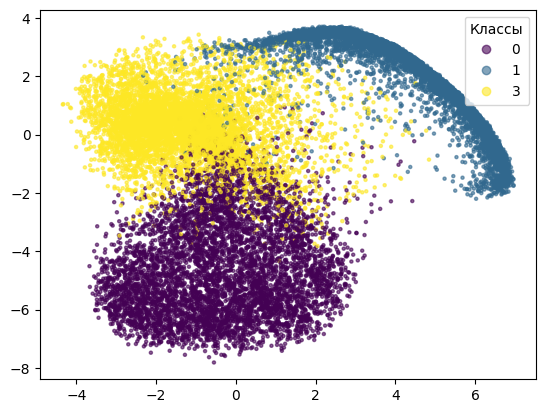

2350/2350 [==============================] - 61s 19ms/step - loss: 0.0436
Epoch 2/10
2349/2350 [============================>.] - ETA: 0s - loss: 0.0384________________________
*** ЭПОХА: 2, loss: 0.038419924676418304 ***
________________________
588/588 [==============================] - 1s 2ms/step


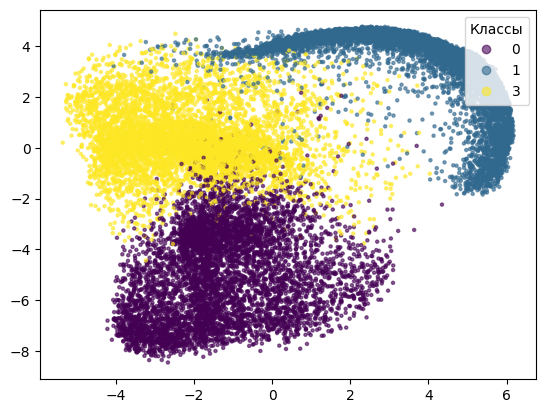

2350/2350 [==============================] - 46s 20ms/step - loss: 0.0384
Epoch 3/10
2348/2350 [============================>.] - ETA: 0s - loss: 0.0365________________________
*** ЭПОХА: 3, loss: 0.036514803767204285 ***
________________________
588/588 [==============================] - 2s 3ms/step


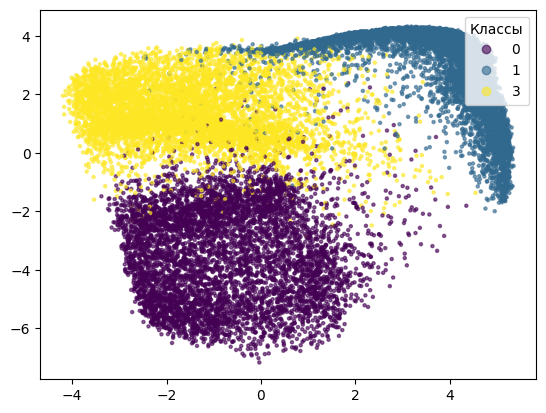

2350/2350 [==============================] - 47s 20ms/step - loss: 0.0365
Epoch 4/10
2349/2350 [============================>.] - ETA: 0s - loss: 0.0355________________________
*** ЭПОХА: 4, loss: 0.035534732043743134 ***
________________________
588/588 [==============================] - 2s 3ms/step


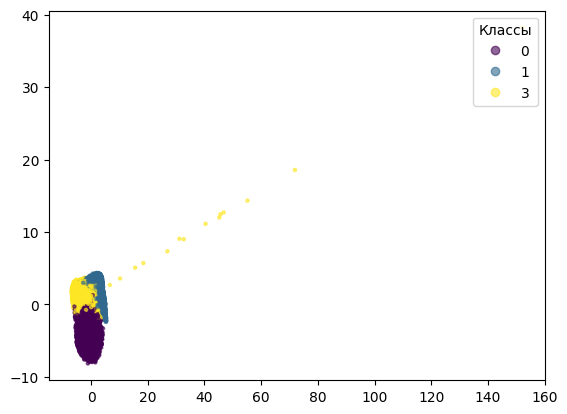

2350/2350 [==============================] - 47s 20ms/step - loss: 0.0355
Epoch 5/10
2350/2350 [==============================] - ETA: 0s - loss: 0.0340________________________
*** ЭПОХА: 5, loss: 0.03402164205908775 ***
________________________
588/588 [==============================] - 2s 3ms/step


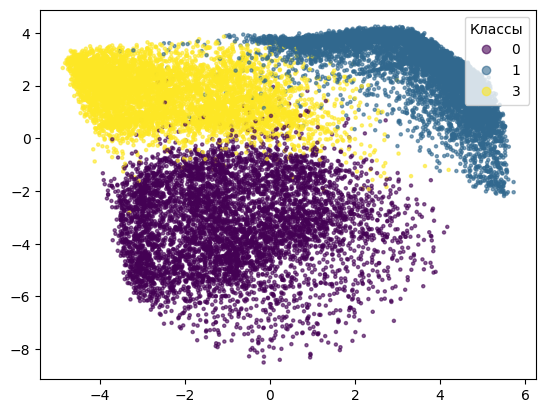

2350/2350 [==============================] - 47s 20ms/step - loss: 0.0340
Epoch 6/10
2348/2350 [============================>.] - ETA: 0s - loss: 0.0335________________________
*** ЭПОХА: 6, loss: 0.03349694237112999 ***
________________________
588/588 [==============================] - 2s 3ms/step


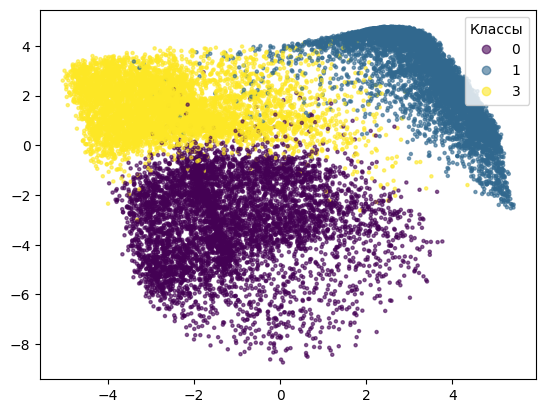

2350/2350 [==============================] - 47s 20ms/step - loss: 0.0335
Epoch 7/10
2350/2350 [==============================] - ETA: 0s - loss: 0.0334________________________
*** ЭПОХА: 7, loss: 0.03335746377706528 ***
________________________
588/588 [==============================] - 2s 3ms/step


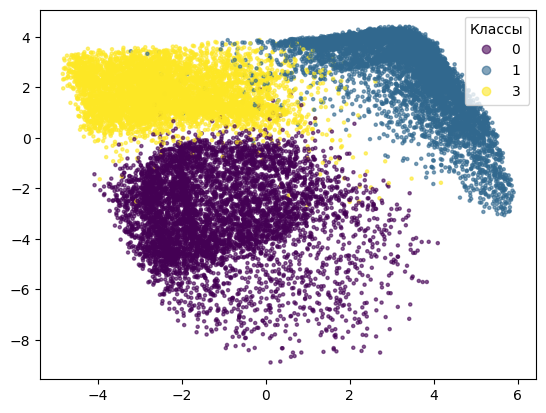

2350/2350 [==============================] - 48s 20ms/step - loss: 0.0334
Epoch 8/10
2349/2350 [============================>.] - ETA: 0s - loss: 0.0329________________________
*** ЭПОХА: 8, loss: 0.032898977398872375 ***
________________________
588/588 [==============================] - 2s 3ms/step


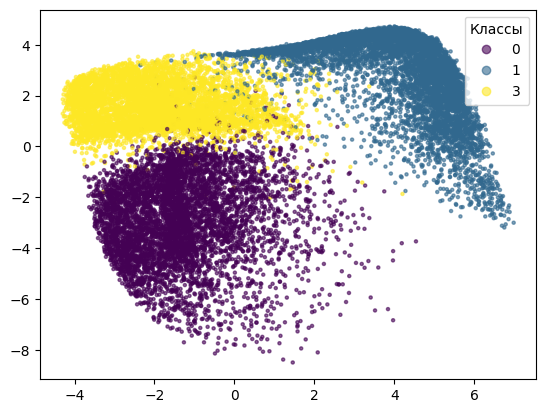

2350/2350 [==============================] - 48s 21ms/step - loss: 0.0329
Epoch 9/10
2349/2350 [============================>.] - ETA: 0s - loss: 0.0326________________________
*** ЭПОХА: 9, loss: 0.03260698541998863 ***
________________________
588/588 [==============================] - 2s 3ms/step


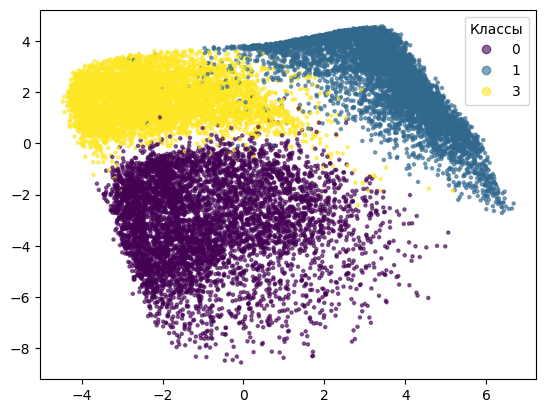

2350/2350 [==============================] - 49s 21ms/step - loss: 0.0326
Epoch 10/10
2350/2350 [==============================] - ETA: 0s - loss: 0.0325________________________
*** ЭПОХА: 10, loss: 0.03247278928756714 ***
________________________
588/588 [==============================] - 2s 3ms/step


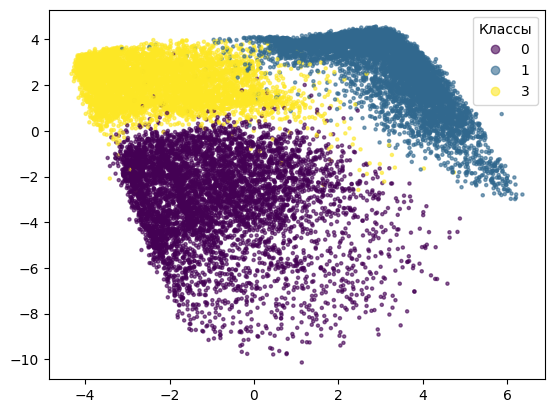

2350/2350 [==============================] - 49s 21ms/step - loss: 0.0325


In [ ]:
# Компиляция модели с выбранным оптимизатором (ПО УСЛОВИЮ ЗАДАЧИ rate 0.001) и функцией потерь MSE
autoencoder.compile(optimizer=Adam(0.001), loss='mse') 

# Обучение автокодировщика на 10 эпохах
autoencoder.fit(X_train, 
                X_train,
                epochs=10,
                batch_size=8,
                shuffle=True,
                callbacks = [ae_callback]
                )

In [ ]:
# путь к папке для хранения моделей
PATH = '/content/my_ae_models'

# создадим папку для моделей, если её еще нет
if not os.path.isdir(PATH):
  os.mkdir(PATH)

In [ ]:
# Сохранение/восстановление параметров модели
autoencoder.save_weights(PATH + '/autoencoder.h3') # Сохраняем модель
autoencoder.load_weights(PATH + '/autoencoder.h3') # Загружаем модель

In [ ]:
# Получение предсказания автокодировщика на тренировочной выборке
pred_train = autoencoder.predict(X_train)

588/588 [==============================] - 5s 7ms/step


In [ ]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(x_data, pred, n=5): 

    plt.figure(figsize=(14, 7))                     # Размер полотна

    for i in range(1, n + 1):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса 

        # Показ картинки с индексом index из набора x_data
        ax = plt.subplot(2, n, i)               # Картинка располагается в верхнем ряду
        plt.imshow(x_data[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(2, n, i + n)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

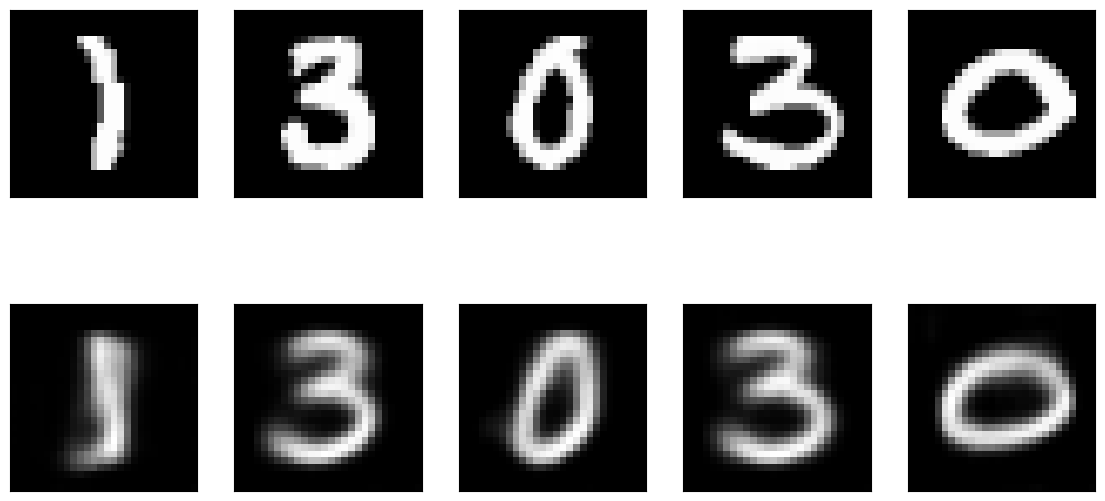

In [ ]:
# Сравнение исходных и восстановленных картинок из тренировочной
plot_images(X_train, pred_train)

# **ВЫВОД: Именно по цифрам 0 1 3 работает более-менее с ошибкой минимальной MSE=0.0325, что по условию задачи <0.034**